In [9]:
import joblib
from matplotlib.colors import LinearSegmentedColormap

from phipsurv.io.data_handler import Config, MetadataHandler, OligosHandler, FeatureManager
from phipsurv.plots.metrics_helpers import *
from phipsurv.plots.helpers import  (
    generate_feature_importance_table, plot_shap_values, plot_table_top_features,
    barplot_counts_fisher_test, boxplot_compare_distribution_by_category)
from phipsurv.survival.helpers import CoxnetWrapper

In [2]:
config_file = "/home/creyna/Vogl-lab_Projects_git/BC-Engl/Metadata/config_file_survival.yaml"
config = Config(config_file)
metadata_handler = MetadataHandler(config)
oligos_handler = OligosHandler(config)
feature_manager = FeatureManager(config, metadata_handler, oligos_handler,
                                 subgroup = 'all',
                                 with_oligos=True,
                                 with_additional_features = True,
                                 filter_by_entropy=False,
                                 prevalence_threshold_min=0,
                                 prevalence_threshold_max=100)
X_train, y_event_train = feature_manager.get_features_target()
y_time_train = X_train["OS months"]
X_train.drop(columns = ["OS months"], inplace = True)
y_time_train = y_time_train.where(y_event_train == 1, -y_time_train) #np.where(y_event, y_time, -y_time)
number_peptides = X_train.shape[1]
X_train.shape

(322, 5272)

# Top peptides selection from survival models (200 replicates)
## Hybrid selection based on frequency and feature importance (SHAP values)

In [3]:
config.figures_dir = "/home/creyna/Vogl-lab_Projects_git/BC-Engl/Survival/antigen_score"
out_dir = "/home/creyna/Vogl-lab_Projects_git/BC-Engl/Survival/antigen_score"
file_path_template = "/home/creyna/Vogl-lab_Projects_git/BC-Engl/Survival/results/nested_XGB-survivalCox_BC-Engl_{}.joblib"
start, end = 1, 200

In [10]:
# Settings
top_k = 30
min_freq = 0.5
n_select = 18 # seems to ha peptides passed freq >= 0.5

# Step 1: gather stats
runs_used, feats, freq_counter, rank_sum, rank_n, mean_abs_sum = process_runs_for_stats(
    file_path_template, start, end, top_k
)

# Step 2: hybrid selection
stats_df, selected_df = hybrid_select(
    feats, runs_used, freq_counter, rank_sum, rank_n, mean_abs_sum,
    min_freq=min_freq, n_select=n_select
)

top_peptides_train = selected_df['feature'].values
top_peptides_train = top_peptides_train[top_peptides_train != "twist_35869"]
#joblib.dump(top_peptides_train, f"{out_dir}/top_peptides_train.pkl")

Pass 1: stats: 100%|██████████| 200/200 [00:29<00:00,  6.71it/s]


In [11]:
top_peptides_train = joblib.load(f"{out_dir}/top_peptides_train.pkl")
top_peptides_train

array(['twist_52478', 'twist_35870', 'agilent_229243', 'agilent_221864',
       'agilent_71450', 'twist_58938', 'agilent_228819', 'twist_87633',
       'twist_47864', 'agilent_241734', 'agilent_198657',
       'agilent_229166', 'agilent_227833', 'agilent_222335',
       'agilent_169922', 'agilent_236613', 'agilent_66572'], dtype=object)

In [56]:
selected_df.to_excel(f"{out_dir}/top_peptides_train_BC-Engl_{number_peptides}.xlsx", index=False)

# Compute Antigen Score and Time-dependent AUC
# Antigen score based on selected top peptides from survival models

In [12]:
max_time_point_risk = 97
antigen_scores, auc_antigen_values_train_full, mean_auc_antigen_train_full = compute_antigen_score_from_joblibs(
    file_path_template=file_path_template,
    start = start, end = end,
    time_train=y_time_train, time_test=y_time_train,
    max_timepoint=max_time_point_risk,
    min_timepoint=1,
    top_peptides=top_peptides_train,
    agg="median"
)

Computing per-run antigen scores: 100%|██████████| 200/200 [00:16<00:00, 11.94it/s]


In [6]:
mu  = antigen_scores.mean(skipna=True)
sig = antigen_scores.std(skipna=True)
mu, sig

(0.03485996303272671, 0.20151465020976794)

In [15]:
antigen_scores_df = pd.DataFrame(antigen_scores, columns = ["Antigen Score"])
antigen_scores_df['Antigen Score (Scaled)'] = (antigen_scores - mu) / sig
antigen_scores_df

,Antigen Score,Antigen Score (Scaled)
SampleName,,
R29P01_34_2014164_BC-Engl-P1_A_T_C2,-0.120234,-0.769642
R29P01_36_2014192_BC-Engl-P1_A_T_C2,-0.114521,-0.741291
R29P01_41_2015164_BC-Engl-P1_A_T_C2,-0.133048,-0.833228
R29P01_43_2015255_BC-Engl-P1_A_T_C2,0.372769,1.676845
R29P01_46_2015329_BC-Engl-P1_A_T_C2,0.205241,0.845503
...,...,...
R30P02_57_2023051_BC-Engl-P6_A_T_C2,0.250285,1.069031
R30P02_58_2023089_BC-Engl-P6_A_T_C2,-0.113737,-0.737402
R30P02_60_2023106_BC-Engl-P6_A_T_C2,-0.289412,-1.609173


## Format antigen score data frame to include scaled and dichotomized vaues (low - high antigen score) based on maxstat R package

In [17]:
#out_dir = "/home/creyna/Vogl-lab_Projects_git/BC-Engl/Survival/antigen_score"
antigen_scores_df, threshold, raw_csv, with_cut_csv = build_antigen_score_df(
    antigen_score=antigen_scores_df,
    y_time=y_time_train.abs(),   # OS months
    y_event=y_event_train, # 0/1
    out_dir=out_dir,
    save_prefix="1antigen_scores_train_RAW",  # customize label
    threshold_method="maxstat",              # or "median"/"percentile"
    percentile=0.5,                          # used only for percentile
    r_seed=1,
    r_B=9999,
)

print("Chosen threshold:", threshold)
print("Saved:", raw_csv, "and", with_cut_csv)

Warning message:
package ‘survival’ was built under R version 4.3.3 


Chosen threshold: -0.07133579
Saved: /home/creyna/Vogl-lab_Projects_git/BC-Engl/Survival/antigen_score/1antigen_scores_train_RAW.csv and /home/creyna/Vogl-lab_Projects_git/BC-Engl/Survival/antigen_score/1antigen_scores_train_RAW_with_cut.csv


In [184]:
antigen_scores_df.to_excel(f"{config.figures_dir}/antigen_scores_train_BC-Engl_{number_peptides}.xlsx", index=True)

# SHAP values

In [18]:
shap_values =  pd.DataFrame(0.0, index=X_train.index, columns=X_train.columns)

for i in range(start, end+1):
    # Construct the file path for the model results based on its ID/seed.
    file_path = file_path_template.format(i)
    results = load(file_path)
    shap_values += results['train_shap_values']

shap_values /= end

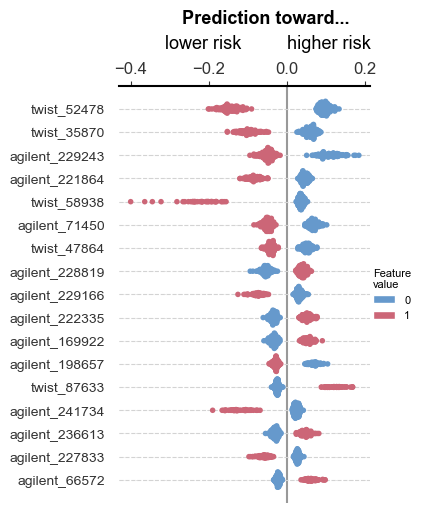

In [19]:
newCmap = LinearSegmentedColormap.from_list("", ['#6699CC', '#CC6677'])
shap_fontsize = {
        'xlabel': 13,
        'ylabel': 13,
        'xticks': 12,
        'yticks': 10,
        'legend': 8,
        'colorbar': 12
}
f, a = plot_shap_values(shap_values.loc[:,top_peptides_train].values, X_train.loc[:,top_peptides_train],
                        cmap=newCmap, max_display=17, figure_size = (5,5), fontsize  = shap_fontsize,
                        add_group_labels=True, x_label = "Prediction toward...", group_tests=['lower risk', 'higher risk'],
                        add_binary_legend=True, legend_labels = ['0', '1'], legend_title = "Feature\nvalue",
                        filename_label=f'nestedCV_survivalModel_BC-Engl_{number_peptides}',
                        save_fig=False, figures_dir=config.figures_dir)
f

## Feature importance table

In [20]:
oligos_metadata = pd.read_pickle("/home/creyna/Vogl-lab_Projects_git/BC-Engl/Metadata/combined_libraries_with_lineages_important_info_nonAAseq.pkl")
oligos_metadata = oligos_metadata[['Description', 'species', 'genus', 'family','order']]
feature_importance_train = generate_feature_importance_table(shap_values.loc[:,top_peptides_train], X_train.loc[:,top_peptides_train], y_event_train, oligos_metadata,
                                                             group_tests = config.group_tests, filename_label=f'1nestedCV_survivalModel_BC-Engl_{number_peptides}', figures_dir = f"{config.figures_dir}")
feature_importance_train

,Peptide ID,SHAP value,Description,Species,Genus,Family,Order,censored,deceased,Ratio
0,twist_52478,0.117400,phosphoprotein 150,Cytomegalovirus humanbeta5,Cytomegalovirus,Orthoherpesviridae,Herpesvirales,54.135338,32.804233,1.650255
1,twist_35870,0.074212,EBNA3C latent protein,Lymphocryptovirus humangamma4,Lymphocryptovirus,Orthoherpesviridae,Herpesvirales,45.112782,30.687831,1.470054
2,agilent_229243,0.071459,Autolysin,Streptococcus pneumoniae,Streptococcus,Streptococcaceae,Lactobacillales,69.172932,60.317460,1.146814
3,agilent_221864,0.059388,Choline binding protein A,Streptococcus pneumoniae,Streptococcus,Streptococcaceae,Lactobacillales,44.360902,28.042328,1.581927
4,twist_58938,0.058462,B B/Ann Arbor/1/86 HA,Betainfluenzavirus influenzae,Betainfluenzavirus,Orthomyxoviridae,Articulavirales,15.037594,8.994709,1.671827
5,agilent_71450,0.057452,staphylococcal protein A,Staphylococcus aureus,Staphylococcus,Staphylococcaceae,Bacillales,64.661654,51.322751,1.259902
6,twist_47864,0.046217,Capsid protein VP26,Lymphocryptovirus humangamma4,Lymphocryptovirus,Orthoherpesviridae,Herpesvirales,53.383459,47.619048,1.121053
7,agilent_228819,0.045665,M protein type 1,Streptococcus pyogenes,Streptococcus,Streptococcaceae,Lactobacillales,55.639098,64.550265,0.861950
8,agilent_229166,0.042965,M protein type 1,Streptococcus pyogenes,Streptococcus,Streptococcaceae,Lactobacillales,32.330827,22.751323,1.421053
9,agilent_222335,0.042023,Iron-regulated surface determinant protein B,Staphylococcus aureus,Staphylococcus,Staphylococcaceae,Bacillales,42.105263,44.444444,0.947368


## Clean the Description column of the Feature importance table and read the new file to create a fig table

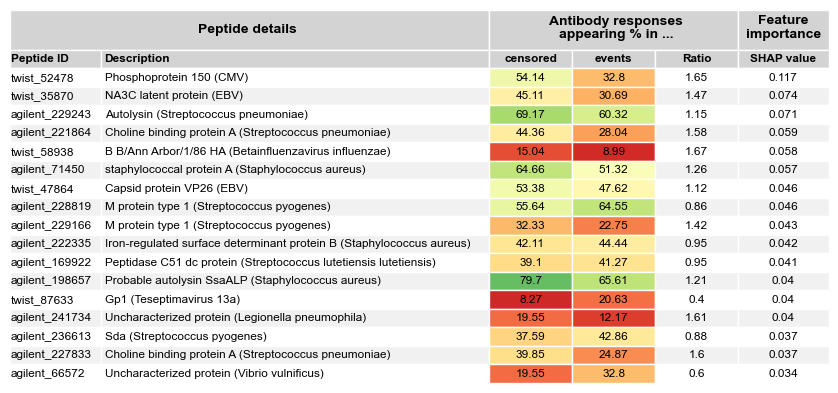

In [22]:
group_tests = ['censored', 'events']
feature_importance_train = pd.read_csv(f'{config.figures_dir}/Table_shap_censored-deceased_nestedCV_survivalModel_BC-Engl_{number_peptides}_with_oligos_mergedSpecies.csv')
fig, axis =plot_table_top_features(feature_importance_train,
                        to_select_features = 17,
                        fig_size=(8.5, 4),
                        group_tests = group_tests,
                        figure_dir = config.figures_dir, filename_label=f"{'-'.join(group_tests)}_survivalModel_BC-Engl", save_fig = True)
fig

# Kaplan-Meier

INFO:phipsurv.plots.metrics_helpers:Figure saved to /home/creyna/Vogl-lab_Projects_git/BC-Engl/Survival/antigen_score/kaplan_meier_1nestedCV_survivalModel_BC-Engl_5272.pdf
INFO:phipsurv.plots.metrics_helpers:Log-Rank Test p-value: 0.0000


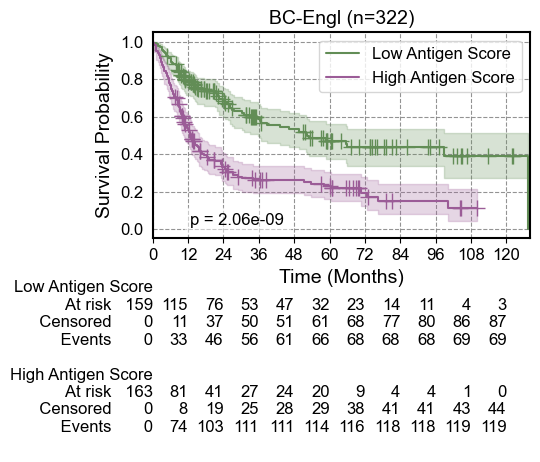

In [23]:
# Assuming the antigen score has been dichotomized into "Antigen Score (Dichotomized)" and you have time and event data in a data frame
labels = {0: 'Low Antigen Score', 1: 'High Antigen Score'}

# Plot for Training Set
f, a = plot_kaplan_meier(antigen_scores_df, 'OS months', 'OS Status', 'Antigen Score (Dichotomized)',
                         title="BC-Engl (n=322)", xlabel="Time (Months)", ylabel="Survival Probability",  labels = labels,
                         color_lines = ["#628D56", "#9B5C97"], tick_space=12, loc_legend='best',
                         save_fig=True, figures_dir=config.figures_dir, suffix_file=f'1nestedCV_survivalModel_BC-Engl_{number_peptides}' )

# Perform log-rank test for Training Set
perform_logrank_test(antigen_scores_df, 'OS months', 'OS Status', 'Antigen Score (Dichotomized)')
f

# Time-dependent AUC

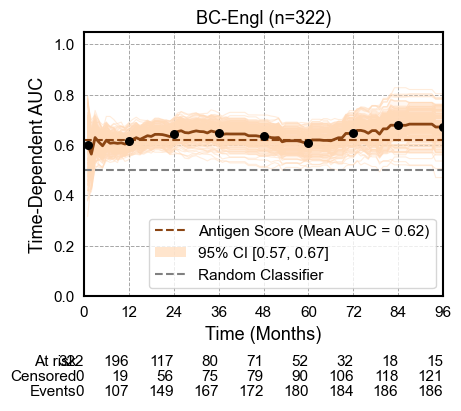

In [24]:
#config.figures_dir =  "/home/creyna/Vogl-lab_Projects_git/HCC/Reports/plots/Figure5"
# --- Prep ensemble stats from your 500×T matrix ---
# time_dependent_auc_df: rows=runs (1..500), cols=time points (e.g., 1..24)
max_time_point_plot = 96
auc_matrix = auc_antigen_values_train_full.copy()

# 95% pointwise CI across runs
ci_lower = auc_matrix.quantile(0.025, axis=0).values
ci_upper = auc_matrix.quantile(0.975, axis=0).values
ci_lower   = np.asarray(ci_lower, dtype=float)
ci_upper   = np.asarray(ci_upper, dtype=float)
# Mean of per-run mean tAUCs for legend label
# (mean_time_dependent_auc: length-500 Series you already computed)


time_points_highlight_train = np.concatenate(([1], np.arange(12, max_time_point_risk, step=12)))
extension_time_points = np.arange(0, max_time_point_plot+1, step=12)
samples_at_risk_train = calculate_samples_at_risk(y_time_train, extension_time_points)#time_points_highlight_test)


fig = plot_time_dependent_auc(auc_matrix, samples_at_risk_train,
                        mean_auc=mean_auc_antigen_train_full,
                        ci_lower=ci_lower, ci_upper=ci_upper,
                        extension_time_points = extension_time_points,
                        time_points_highlight=time_points_highlight_train,
                        time_measure = "Months", max_time_point = max_time_point_plot,
                        color_auc = "saddlebrown", color_mean="saddlebrown", color_ci="peachpuff",
                        run_lines_color = "peachpuff", run_lines_alpha = 0.5,
                        figures_dir = config.figures_dir, save_fig=False)

ax_auc = fig.get_axes()[0]
# Assign new legend
ax_auc.set_title("BC-Engl (n=322)", fontsize=13)
save_path = Path(config.figures_dir) / f'1time-dependent_auc_nestedCV_survivalModel_BC-Engl_{number_peptides}.pdf'
fig.set_size_inches(4.5, 4)
plt.savefig(save_path, dpi=600, bbox_inches='tight')
fig

# Responders vs antigen score

In [25]:
clinical_meta = antigen_scores_df.join(metadata_handler.get_individuals_metadata_df().responders)

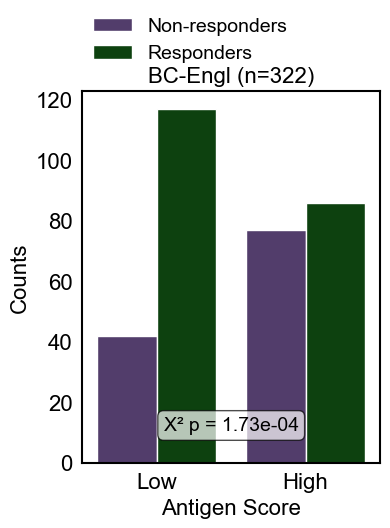

In [26]:
mapping_antigen = {0: 'Low', 1: 'High'}
fontsize = {"title": 16, "xlabel": 16, "ylabel": 16, "xtick": 16, "ytick": 16,"legend": 14, "annotation": 14}
mapping = {1: 'Responders', 0: 'Non-responders'}
palette = {
        'Responders': '#054907',  # dark blue
        'Non-responders': '#513573'   # dark red
    }
# Call the function
fig = barplot_counts_fisher_test(
    df=clinical_meta,
    title="BC-Engl (n=322)",
    cat_var1='responders',
    cat_var2='Antigen Score (Dichotomized)',
    method="chisquare",
    legend_title='',
    y_label='Counts',
    x_label='Antigen Score',
    mapping1=mapping,
    mapping2=mapping_antigen,
    figsize=(4, 5.5),
    palette=palette,
    save_path=config.figures_dir,
    suffix_file=f"1nestedCV_survivalModel_BC-Engl_ORR_{number_peptides}",
    fontsize=fontsize
)
fig

Mann–Whitney Test statistic: 9259.0, p-value: 0.000


/home/creyna/miniconda3/envs/ML_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/creyna/miniconda3/envs/ML_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/creyna/miniconda3/envs/ML_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


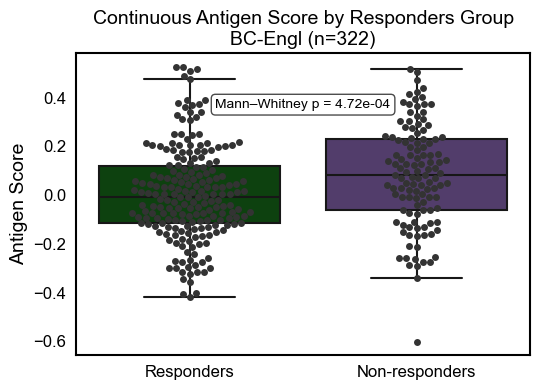

In [27]:
palette = {
        'Responders': '#054907',  # dark blue
        'Non-responders': '#513573'   # dark red
    }
fig = boxplot_compare_distribution_by_category(clinical_meta,
                                               cont_var='Antigen Score',
                                               title="Continuous Antigen Score by Responders Group\nBC-Engl (n=322)",
                                               cat_var='responders',
                                               cat_mapping=mapping,
                                               palette=palette,
                                               x_label="",
                                               y_label="Antigen Score",
                                               #title="Antigen Score by DCR Group",
                                               figsize=(5.5,4),
                                               save_path=config.figures_dir,
                                               suffix_file=f"1nestedCV_survivalModel_BC-Engl_ORR_{number_peptides}"
                                               )
fig